# 名字生成任务

## 导入库和基础组件

In [98]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import itertools
import collections
import matplotlib.pyplot as plt
import math

# 位置编码
class NamePositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# 多头自注意力
class NameMultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads, qk_dim):
        super().__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.qk_dim = qk_dim
        
        self.W_q = nn.Linear(embed_size, heads * qk_dim)
        self.W_k = nn.Linear(embed_size, heads * qk_dim)
        self.W_v = nn.Linear(embed_size, heads * qk_dim)
        self.W_o = nn.Linear(heads * qk_dim, embed_size)
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        seq_len = query.size(1)
        
        # 线性变换
        Q = self.W_q(query).view(batch_size, seq_len, self.heads, self.qk_dim).transpose(1, 2)
        K = self.W_k(key).view(batch_size, seq_len, self.heads, self.qk_dim).transpose(1, 2)
        V = self.W_v(value).view(batch_size, seq_len, self.heads, self.qk_dim).transpose(1, 2)
        
        # 计算注意力
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.qk_dim)
        
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = torch.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_weights, V)
        
        # 合并多头
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, self.heads * self.qk_dim)
        
        return self.W_o(attention_output)

# 前馈网络
class NameFeedForward(nn.Module):
    def __init__(self, embed_size, ff_hidden_size, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(embed_size, ff_hidden_size)
        self.linear2 = nn.Linear(ff_hidden_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.linear2(self.dropout(torch.relu(self.linear1(x))))

# Transformer Encoder层
class NameTransformerEncoderLayer(nn.Module):
    def __init__(self, embed_size, heads, qk_dim, ff_hidden_size, dropout=0.1):
        super().__init__()
        self.self_attention = NameMultiHeadAttention(embed_size, heads, qk_dim)
        self.feed_forward = NameFeedForward(embed_size, ff_hidden_size, dropout)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # 自注意力
        attn_output = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # 前馈网络
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

# Transformer Decoder层
class NameTransformerDecoderLayer(nn.Module):
    def __init__(self, embed_size, heads, qk_dim, ff_hidden_size, dropout=0.1):
        super().__init__()
        self.self_attention = NameMultiHeadAttention(embed_size, heads, qk_dim)
        self.cross_attention = NameMultiHeadAttention(embed_size, heads, qk_dim)
        self.feed_forward = NameFeedForward(embed_size, ff_hidden_size, dropout)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.norm3 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, encoder_output, tgt_mask=None, src_mask=None):
        # 掩码自注意力
        attn_output = self.self_attention(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # 交叉注意力
        cross_attn_output = self.cross_attention(x, encoder_output, encoder_output, src_mask)
        x = self.norm2(x + self.dropout(cross_attn_output))
        
        # 前馈网络
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        
        return x

# Transformer Encoder
class NameTransformerEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, heads, qk_dim, 
                 ff_hidden_size, dropout=0.1, max_length=100):
        super().__init__()
        self.embed_size = embed_size
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = NamePositionalEncoding(embed_size, max_length)
        self.layers = nn.ModuleList([
            NameTransformerEncoderLayer(embed_size, heads, qk_dim, ff_hidden_size, dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        x = self.word_embedding(x) * math.sqrt(self.embed_size)
        x = self.positional_encoding(x)
        x = self.dropout(x)
        
        for layer in self.layers:
            x = layer(x, mask)
        
        return x

# Transformer Decoder
class NameTransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, heads, qk_dim, 
                 ff_hidden_size, dropout=0.1, max_length=100):
        super().__init__()
        self.embed_size = embed_size
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = NamePositionalEncoding(embed_size, max_length)
        self.layers = nn.ModuleList([
            NameTransformerDecoderLayer(embed_size, heads, qk_dim, ff_hidden_size, dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, encoder_output, tgt_mask=None, src_mask=None):
        x = self.word_embedding(x) * math.sqrt(self.embed_size)
        x = self.positional_encoding(x)
        x = self.dropout(x)
        
        for layer in self.layers:
            x = layer(x, encoder_output, tgt_mask, src_mask)
        
        return x

print("基础组件定义完成！")

基础组件定义完成！


## 数据准备函数

In [99]:
# 数据准备函数
def prepare_name_data():
    try:
        # 读取数据
        df = pd.read_csv("English_Cn_Name_Corpus（48W）.txt", header=None, names=["name"], skiprows=2)
        names = df["name"].values
        
        print(f"数据文件读取成功，共{len(names)}个名字")
        print(f"前5个名字: {names[:5]}")
        
        # 计算单字频率
        chars = [list(name) for name in names]
        chars_flatten = list(itertools.chain(*chars))
        freq = collections.Counter(chars_flatten)
        freq = pd.DataFrame(freq.items(), columns=["char", "freq"])
        freq = freq.sort_values(by="freq", ascending=False)
        
        # 选择常见字（增加字典大小）
        dict_size = 100  # 增加字典大小
        charset_size = dict_size + 1  # 为EOS预留
        dict = list(freq["char"].values[:dict_size])
        dict_set = set(dict)
        
        # 过滤数据
        dat = list(filter(lambda name: set(name).issubset(dict_set), names))
        
        print(f"过滤后数据大小: {len(dat)}")
        print(f"字典大小: {dict_size}")
        print(f"字符集大小: {charset_size}")
        print(f"前10个常用字: {dict[:10]}")
        
        # 分割训练和测试数据
        train_size = int(0.8 * len(dat))
        train = dat[:train_size]
        test = dat[train_size:]
        
        print(f"训练集大小: {len(train)}")
        print(f"测试集大小: {len(test)}")
        
        return train, test, dict, charset_size
        
    except Exception as e:
        print(f"数据准备过程中出现错误: {e}")
        return None, None, None, None

# 运行数据准备
train, test, dict, charset_size = prepare_name_data()

数据文件读取成功，共425029个名字
前5个名字: ['阿阿奥卢' '阿阿巴伊' '阿阿贝伊奥卢' '阿阿比金' '阿阿尔坦']
过滤后数据大小: 232444
字典大小: 100
字符集大小: 101
前10个常用字: ['尔', '斯', '拉', '克', '特', '德', '尼', '夫', '利', '科']
训练集大小: 185955
测试集大小: 46489


## 字符索引函数

In [100]:
# 字符索引函数
def char2index(char, dict):
    """字符转索引"""
    return dict.index(char)

def name2index(name, dict):
    """名字转索引序列"""
    return [char2index(char, dict) for char in name]

def index2char(index, dict):
    """索引转字符"""
    return dict[index]

def name_name2index(name, dict):
    """名字转索引序列（兼容函数）"""
    return name2index(name, dict)

def name_char2index(char, dict):
    """字符转索引（兼容函数）"""
    return char2index(char, dict)

# 测试索引函数
print("测试索引函数:")
test_name = "阿库卡"
indices = name2index(test_name, dict)
print(f"名字: {test_name} -> 索引: {indices}")
print(f"索引: {indices} -> 名字: {''.join([index2char(i, dict) for i in indices])}")

测试索引函数:
名字: 阿库卡 -> 索引: [19, 47, 11]
索引: [19, 47, 11] -> 名字: 阿库卡


## Transformer模型（防止过拟合）

In [101]:
# 修复模型类的generate方法
class ImprovedNameGenerator(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, heads, qk_dim, 
                 ff_hidden_size, dropout=0.1, max_length=100):
        super().__init__()
        self.encoder = NameTransformerEncoder(
            vocab_size, embed_size, num_layers, heads, qk_dim, 
            ff_hidden_size, dropout, max_length
        )
        self.decoder = NameTransformerDecoder(
            vocab_size, embed_size, num_layers, heads, qk_dim, 
            ff_hidden_size, dropout, max_length
        )
        
        # 输出投影层
        self.output_projection = nn.Linear(embed_size, vocab_size)
        self.vocab_size = vocab_size
        self.max_length = max_length
        
        # 权重初始化
        self._init_weights()
    
    def _init_weights(self):
        """权重初始化"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.1)
    
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        # Encoder处理源序列
        encoder_output = self.encoder(src, src_mask)
        
        # Decoder处理目标序列
        decoder_output = self.decoder(tgt, encoder_output, tgt_mask, src_mask)
        
        # 输出投影
        output = self.output_projection(decoder_output)
        return output
    
    def generate(self, start_char, dict, max_length=10, temperature=1.0, top_k=10):
        """修复后的生成函数"""
        self.eval()
        
        start_idx = char2index(start_char, dict)
        generated = [start_idx]
        
        with torch.no_grad():
            for _ in range(max_length - 1):
                # 当前输入
                current_input = torch.tensor([generated], dtype=torch.long)
                
                # 前向传播 - 修复：使用相同的输入作为源和目标
                output = self(current_input, current_input)
                next_token_logits = output[0, -1, :] / temperature
                
                # Top-k采样
                if top_k > 0:
                    top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k)
                    next_token_logits = torch.full_like(next_token_logits, float('-inf'))
                    next_token_logits[top_k_indices] = top_k_logits
                
                # 避免选择填充token
                next_token_logits[0] = float('-inf')
                
                # 采样
                probs = torch.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, 1).item()
                
                # 检查是否结束
                if next_token == 0 or next_token == self.vocab_size - 1:
                    break
                    
                generated.append(next_token)
        
        # 转换为字符
        generated_name = ''.join([index2char(idx, dict) for idx in generated if idx < len(dict)])
        return generated_name

# 重新创建模型
print("重新创建修复后的模型...")
model = ImprovedNameGenerator(vocab_size=charset_size, embed_size=64, num_layers=2, heads=4, 
                             qk_dim=64, ff_hidden_size=128, dropout=0.3, max_length=10)
print("修复后的模型创建成功！")

# 测试修复后的生成
print("测试修复后的生成功能...")
test_chars = ["阿", "库", "卡", "帕"]
for char in test_chars:
    try:
        generated_name = model.generate(char, dict, temperature=1.0)
        print(f"{char} -> {generated_name}")
    except Exception as e:
        print(f"{char} -> 生成失败: {e}")

重新创建修复后的模型...
修复后的模型创建成功！
测试修复后的生成功能...
阿 -> 阿普布布韦韦布费费耶
库 -> 库希普耶穆赫普阿卡卡
卡 -> 卡拉布尼巴赫普尼阿赫
帕 -> 帕塔赫谢穆巴特阿费巴


##  改进的训练函数（防止过拟合)

开始改进训练（防止过拟合 + 详细记录 + 最低损失终止）...
训练集大小: 185955
验证集大小: 46489
模型参数: embed_size=64, num_layers=2, dropout=0.3
早停耐心值: 10
最低训练损失终止阈值: 0.5
批次大小: 258
总批次数: 721
--------------------------------------------------------------------------------

Epoch 1/3 开始训练
------------------------------------------------------------
  Epoch 1 | Batch  10 | Loss: 2.0006 | Avg Loss: 2.8842 | LR: 0.000500
  Epoch 1 | Batch  20 | Loss: 1.8673 | Avg Loss: 2.4289 | LR: 0.000500
  Epoch 1 | Batch  30 | Loss: 1.4617 | Avg Loss: 2.1787 | LR: 0.000500
  Epoch 1 | Batch  40 | Loss: 1.3250 | Avg Loss: 1.9836 | LR: 0.000500
  Epoch 1 | Batch  50 | Loss: 1.1928 | Avg Loss: 1.8368 | LR: 0.000500
  Epoch 1 | Batch  60 | Loss: 1.0517 | Avg Loss: 1.7104 | LR: 0.000500
  Epoch 1 | Batch  70 | Loss: 0.9023 | Avg Loss: 1.6021 | LR: 0.000500
  Epoch 1 | Batch  80 | Loss: 0.7586 | Avg Loss: 1.5035 | LR: 0.000500
  Epoch 1 | Batch  90 | Loss: 0.6817 | Avg Loss: 1.4143 | LR: 0.000500
  Epoch 1 | Batch 100 | Loss: 0.5763 | Avg Loss: 1

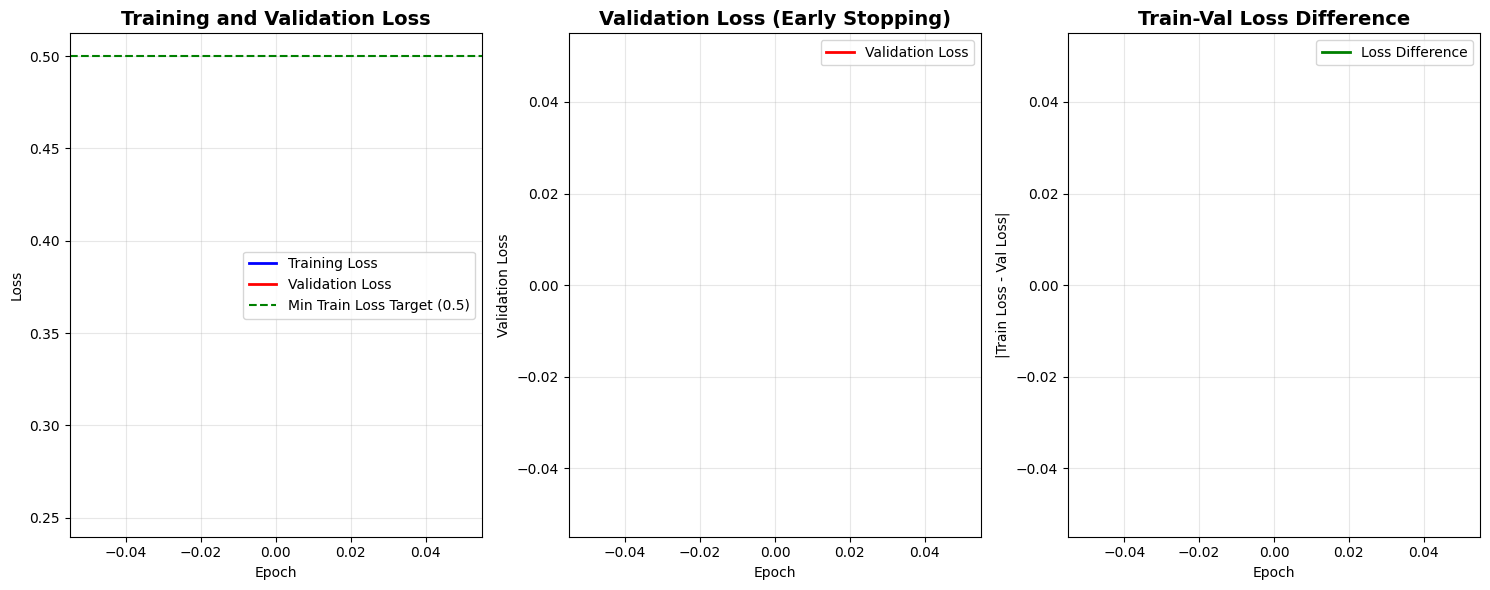


训练完成总结:
总训练轮数: 1
最佳验证损失: inf
最终训练损失: 0.2520
训练过程中出现错误: list index out of range


In [102]:
# 改进的训练函数（防止过拟合 + 详细训练过程记录 + 最低损失终止）
def train_name_generator_improved(train_data, test_data, dict, charset_size, patience=10, min_delta=0.001, min_train_loss=0.5):
    """
    改进的训练函数，防止过拟合，并记录详细训练过程
    添加最低训练损失终止条件
    """
    # 模型参数（适中大小）
    vocab_size = charset_size
    embed_size = 64
    num_layers = 2
    heads = 4
    qk_dim = 64
    ff_hidden_size = 128
    dropout = 0.3  # 增加dropout
    max_length = 10
    
    # 创建模型
    model = ImprovedNameGenerator(vocab_size, embed_size, num_layers, heads, qk_dim, 
                                 ff_hidden_size, dropout, max_length)
    
    # 训练参数
    criterion = nn.CrossEntropyLoss(ignore_index=charset_size-1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # 降低学习率
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # 早停相关变量
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # 训练循环
    nepoch = 3
    batch_size = 258
    losses = []
    val_losses = []
    
    print(f"训练集大小: {len(train_data)}")
    print(f"验证集大小: {len(test_data)}")
    print(f"模型参数: embed_size={embed_size}, num_layers={num_layers}, dropout={dropout}")
    print(f"早停耐心值: {patience}")
    print(f"最低训练损失终止阈值: {min_train_loss}")
    print(f"批次大小: {batch_size}")
    print(f"总批次数: {len(train_data) // batch_size + (1 if len(train_data) % batch_size > 0 else 0)}")
    print("-" * 80)
    
    for epoch in range(nepoch):
        # 训练阶段
        model.train()
        total_loss = 0
        n_batches = 0
        
        # 随机打乱训练数据
        train_indices = np.random.permutation(len(train_data))
        
        print(f"\nEpoch {epoch + 1}/{nepoch} 开始训练")
        print("-" * 60)
        
        for i in range(0, len(train_data), batch_size):
            batch_indices = train_indices[i:i+batch_size]
            batch_names = [train_data[j] for j in batch_indices]
            
            # 转换为tensor
            batch_inputs = []
            batch_targets = []
            
            for name in batch_names:
                indices = name2index(name, dict)
                if len(indices) < max_length:
                    indices.extend([0] * (max_length - len(indices)))
                else:
                    indices = indices[:max_length]
                
                input_seq = indices[:-1]
                target_seq = indices[1:]
                
                batch_inputs.append(input_seq)
                batch_targets.append(target_seq)
            
            batch_inputs = torch.tensor(batch_inputs, dtype=torch.long)
            batch_targets = torch.tensor(batch_targets, dtype=torch.long)
            
            # 前向传播
            optimizer.zero_grad()
            outputs = model(batch_inputs, batch_targets)
            
            # 计算损失
            loss = criterion(outputs.view(-1, vocab_size), batch_targets.view(-1))
            
            # 反向传播
            loss.backward()
            
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            total_loss += loss.item()
            n_batches += 1
            
            # 每10个batch输出一次训练过程
            if n_batches % 10 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                avg_loss_so_far = total_loss / n_batches
                print(f"  Epoch {epoch + 1} | Batch {n_batches:3d} | Loss: {loss.item():.4f} | Avg Loss: {avg_loss_so_far:.4f} | LR: {current_lr:.6f}")
        
        avg_train_loss = total_loss / n_batches
        losses.append(avg_train_loss)
        
        print(f"  Epoch {epoch + 1} 训练完成 | 平均训练损失: {avg_train_loss:.4f}")
        
        # 检查最低训练损失终止条件
        if avg_train_loss <= min_train_loss:
            print(f"  训练损失已达到目标阈值 {min_train_loss}，提前终止训练！")
            print(f"  终止位置: Epoch {epoch + 1}, 最终训练损失: {avg_train_loss:.4f}")
            break
        
        # 验证阶段
        model.eval()
        val_loss = 0
        val_batches = 0
        
        print(f"  开始验证...")
        
        with torch.no_grad():
            for i in range(0, len(test_data), batch_size):
                batch_names = test_data[i:i+batch_size]
                
                batch_inputs = []
                batch_targets = []
                
                for name in batch_names:
                    indices = name2index(name, dict)
                    if len(indices) < max_length:
                        indices.extend([0] * (max_length - len(indices)))
                    else:
                        indices = indices[:max_length]
                    
                    input_seq = indices[:-1]
                    target_seq = indices[1:]
                    
                    batch_inputs.append(input_seq)
                    batch_targets.append(target_seq)
                
                batch_inputs = torch.tensor(batch_inputs, dtype=torch.long)
                batch_targets = torch.tensor(batch_targets, dtype=torch.long)
                
                outputs = model(batch_inputs, batch_targets)
                loss = criterion(outputs.view(-1, vocab_size), batch_targets.view(-1))
                
                val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        # 学习率调度
        scheduler.step(avg_val_loss)
        
        print(f"  验证完成 | 验证损失: {avg_val_loss:.4f}")
        print(f"  Epoch {epoch + 1} 总结 | 训练损失: {avg_train_loss:.4f} | 验证损失: {avg_val_loss:.4f} | 学习率: {optimizer.param_groups[0]['lr']:.6f}")
        
        # 早停检查
        if avg_val_loss < best_loss - min_delta:
            best_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"  验证损失改善到 {best_loss:.4f}，保存最佳模型")
        else:
            patience_counter += 1
            print(f"  验证损失未改善，耐心计数器: {patience_counter}/{patience}")
            
            if patience_counter >= patience:
                print(f"  早停触发！连续 {patience} 个epoch验证损失未改善")
                print(f"  终止位置: Epoch {epoch + 1}, 最佳验证损失: {best_loss:.4f}")
                break
        
        # 每个epoch都测试生成
        print(f"  测试生成 (Epoch {epoch + 1}):")
        test_chars = ["阿", "库", "卡", "帕"]
        for char in test_chars:
            try:
                generated_name = model.generate(char, dict, temperature=1.0)
                print(f"    {char} -> {generated_name}")
            except:
                print(f"    {char} -> 生成失败")
        print("  " + "-" * 40)
        
        print("=" * 80)
    
    # 恢复最佳模型
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("已恢复最佳模型状态")
    
    # 绘制损失曲线
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    plt.axhline(y=min_train_loss, color='green', linestyle='--', label=f'Min Train Loss Target ({min_train_loss})')
    plt.title("Training and Validation Loss", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    plt.title("Validation Loss (Early Stopping)", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    # 计算训练和验证损失的差值
    loss_diff = [abs(train_loss - val_loss) for train_loss, val_loss in zip(losses, val_losses)]
    plt.plot(loss_diff, label='Loss Difference', color='green', linewidth=2)
    plt.title("Train-Val Loss Difference", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch")
    plt.ylabel("|Train Loss - Val Loss|")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 训练总结
    print("\n" + "="*80)
    print("训练完成总结:")
    print(f"总训练轮数: {len(losses)}")
    print(f"最佳验证损失: {best_loss:.4f}")
    print(f"最终训练损失: {losses[-1]:.4f}")
    print(f"最终验证损失: {val_losses[-1]:.4f}")
    print(f"过拟合程度: {abs(losses[-1] - val_losses[-1]):.4f}")
    print(f"最低训练损失目标: {min_train_loss}")
    print(f"是否达到目标: {'是' if losses[-1] <= min_train_loss else '否'}")
    print("="*80)
    
    return model

# 运行改进的训练
print("开始改进训练（防止过拟合 + 详细记录 + 最低损失终止）...")
try:
    model = train_name_generator_improved(train, test, dict, charset_size, patience=10, min_delta=0.001, min_train_loss=0.5)
    print("改进训练完成！")
except Exception as e:
    print(f"训练过程中出现错误: {e}")

## 综合测试函数

In [103]:
# 综合测试函数
def test_name_generation_comprehensive(model, dict):
    """综合测试名字生成"""
    test_chars = ["阿", "库", "卡", "帕", "尔", "斯", "拉", "克"]
    temperatures = [0.5, 1.0, 1.5, 2.0]
    
    print("综合名字生成测试:")
    print("=" * 60)
    
    for char in test_chars:
        print(f"\n起始字符: {char}")
        print("-" * 30)
        
        for temp in temperatures:
            try:
                generated_name = model.generate(char, dict, temperature=temp)
                print(f"  温度 {temp}: {generated_name}")
            except Exception as e:
                print(f"  温度 {temp}: 生成失败 - {e}")

# 运行综合测试
test_name_generation_comprehensive(model, dict)

综合名字生成测试:

起始字符: 阿
------------------------------
  温度 0.5: 阿布普安勒沙迪赫迪赫
  温度 1.0: 阿布普费安费林阿迪迪
  温度 1.5: 阿布耶耶费普费兰兰耶
  温度 2.0: 阿布卡尼卡阿迪德拉阿

起始字符: 库
------------------------------
  温度 0.5: 库卡尼谢谢阿巴普卡巴
  温度 1.0: 库卡阿谢尼普普赫赫卡
  温度 1.5: 库希卡拉巴赫普费费费
  温度 2.0: 库巴谢古阿赫谢林哈阿

起始字符: 卡
------------------------------
  温度 0.5: 卡拉耶尼谢卡尼谢谢谢
  温度 1.0: 卡兹哈谢尼耶沃谢哈基
  温度 1.5: 卡阿德布普卡拉布拉迪
  温度 2.0: 卡拉尼谢普尼谢阿基普

起始字符: 帕
------------------------------
  温度 0.5: 帕耶耶拉布卡谢兰阿赫
  温度 1.0: 帕尼尼谢普谢巴尼谢阿
  温度 1.5: 帕赫布普谢图巴阿图赫
  温度 2.0: 帕塔韦普兰林迪赫赫普

起始字符: 尔
------------------------------
  温度 0.5: 尔阿拉布费韦基费赫费
  温度 1.0: 尔塔布费费谢阿德阿迪
  温度 1.5: 尔尼尼谢阿兹姆卡尼普
  温度 2.0: 尔罗耶阿尼谢法巴阿普

起始字符: 斯
------------------------------
  温度 0.5: 斯赫纳布布布费赫费阿
  温度 1.0: 斯列穆达阿迪尼兹普兰
  温度 1.5: 斯赫穆普尼费巴尼阿赫
  温度 2.0: 斯比达赫普普迪沃谢费

起始字符: 拉
------------------------------
  温度 0.5: 拉普普费赫兰德兰迪迪
  温度 1.0: 拉韦耶韦塞普赫比赫赫
  温度 1.5: 拉哈利巴卡特德德赫普
  温度 2.0: 拉韦韦塔阿费谢巴安基

起始字符: 克
------------------------------
  温度 0.5: 克尼普阿普普沃普耶布
  温度 1.0: 克罗谢泰伊哈卡巴费巴
  温度 1.5: 克姆巴谢谢巴林哈巴卡
  温度 2.0: 克哈基卡基费德迪佩

## 批量生成测试

In [104]:
# 批量生成测试
def batch_generation_test(model, dict, num_samples=20):
    """批量生成测试"""
    print(f"批量生成测试（{num_samples}个样本）:")
    print("=" * 50)
    
    # 随机选择起始字符
    start_chars = np.random.choice(dict[:20], num_samples)
    
    generated_names = []
    for i, start_char in enumerate(start_chars):
        try:
            generated_name = model.generate(start_char, dict, temperature=1.0, top_k=10)
            generated_names.append(generated_name)
            print(f"{i+1:2d}. {start_char} -> {generated_name}")
        except Exception as e:
            print(f"{i+1:2d}. {start_char} -> 生成失败: {e}")
            generated_names.append("生成失败")
    
    # 统计生成结果
    unique_names = len(set(generated_names))
    print(f"\n统计结果:")
    print(f"总生成数: {len(generated_names)}")
    print(f"唯一名字数: {unique_names}")
    print(f"多样性比例: {unique_names/len(generated_names):.2%}")
    
    return generated_names

# 运行批量生成测试
generated_names = batch_generation_test(model, dict, num_samples=20)

批量生成测试（20个样本）:
 1. 尔 -> 尔尼尼尼姆阿普阿德阿
 2. 维 -> 维德兰德巴阿阿迪卡图
 3. 格 -> 格杜希阿尼普谢普兰卡
 4. 斯 -> 斯恩布列穆阿列迪拉基
 5. 基 -> 基安普普卡赫普费基迪
 6. 拉 -> 拉内兰埃谢普阿迪迪费
 7. 特 -> 特阿穆阿赫费德德阿迪
 8. 尼 -> 尼姆耶基塞普普普费基
 9. 科 -> 科耶韦哈古基费基普费
10. 奇 -> 奇谢谢托哈尼塞普谢尼
11. 拉 -> 拉韦耶塔赫费尼耶基塞
12. 维 -> 维安普卡穆奥赫耶兰布
13. 夫 -> 夫纳卡姆卡耶阿耶兹巴
14. 里 -> 里尼谢托普兰普谢林迪
15. 科 -> 科普卡尼巴佩基费基卡
16. 特 -> 特赫布耶兰耶耶兹阿尼
17. 维 -> 维谢谢普卡普兰德穆谢
18. 格 -> 格巴基哈古普费基阿赫
19. 罗 -> 罗托比耶耶普卡卡阿耶
20. 利 -> 利德霍沙德阿尼阿迪拉

统计结果:
总生成数: 20
唯一名字数: 20
多样性比例: 100.00%


## 模型保存和加载

In [105]:
# 模型保存和加载
def save_model(model, filepath="transformer_name_generator.pt"):
    """保存模型"""
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'vocab_size': model.vocab_size,
            'embed_size': 64,
            'num_layers': 2,
            'heads': 4,
            'qk_dim': 64,
            'ff_hidden_size': 128,
            'dropout': 0.3,
            'max_length': 10
        }
    }, filepath)
    print(f"模型已保存到: {filepath}")

def load_model(filepath="transformer_name_generator.pt"):
    """加载模型"""
    checkpoint = torch.load(filepath, map_location='cpu')
    config = checkpoint['model_config']
    
    model = ImprovedNameGenerator(**config)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"模型已从 {filepath} 加载")
    return model

# 保存模型
save_model(model)

# 测试加载模型
loaded_model = load_model()
print("模型加载测试成功！")

模型已保存到: transformer_name_generator.pt
模型已从 transformer_name_generator.pt 加载
模型加载测试成功！
